# Training the model for Analysis
In this notebook, we will explain how to train your model with the objective of dataset analysis. Here, we optimize to conserve multiple annotations at the same time (e.g. clonotype and celltype). You can determine the influence of both modalities (TCR via clonotype, GEX via celltypes) by specifying a weight for annotation. This might require retraining on a couple of weight values for finding a mixture suitable for your analysis.

In [1]:
# comet-ml must be imported before torch and sklearn
import comet_ml
import scanpy as sc

import sys
sys.path.append('..')

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Data Preperation
First we load the data via the Scanpy API. This data is derived from the 10x Application note "A new way of exploring immunity". Please follow the notebook "preprocessing/10x_preprocessing.ipynb" (https://github.com/SchubertLab/mvTCR_reproducibility/tree/master/preprocessing) to derive this dataset. We will use the second donor downsampled to 3000 cells and only cells that have a binder with a sufficient amount of counts.

In [2]:
path_data = '../../data/10x_CD8TC/new/v7_avidity.h5ad'
adata = sc.read(path_data)

/home/jan/anaconda3/envs/mvtcr_n1/lib/python3.11/site-packages/anndata/_core/aligned_mapping.py:64: ExperimentalFeatureWarning: Support for Awkward Arrays is currently experimental. Behavior may change in the future. Please report any issues you may encounter!
  warnings.warn(


In [3]:
import config.constants_10x as const

adata = adata[adata.obs['donor']=='donor_2']
adata = adata[adata.obs['binding_name']!='no_data']
adata = adata[adata.obs['binding_name'].isin(const.HIGH_COUNT_ANTIGENS)]
adata = adata[0:3000, :]

Then we divide the data into training and validation data. Typically, a split of 20% validation data was used. The data is splitted to uniquely group 'clonotype' to either training or validation set.

In [4]:
import mvtcr.utils_training as utils
from mvtcr.utils_preprocessing import Preprocessing
utils.fix_seeds(42)

train, val = Preprocessing.group_shuffle_split(adata, group_col='clonotype', val_split=0.20, random_seed=42)
adata.obs['set'] = 'train'
adata.obs.loc[val.obs.index, 'set'] = 'val'
adata.obs['set'].value_counts()

set
train    2581
val       419
Name: count, dtype: int64

## Defining the model parameters
We need to proivde the model a couple of parameters:
- study_name: Name for logging
- comet_workspace: we logged some of the experiments via Comet-ML. This gives you more information on the training process, but is not needed. We will therefore use None here. Otherwise, specifiy the workspace name of your Comet-ML project.
- model_name: assigns which model is used from (rna, tcr, moe, poe, concat). We will use the best performing moe.
- balanced_sample: oversample rare elements of this column. Recommended to use a column storing the clonotype to avoid overfitting.
- metadata: annotation to color the umaps when storing immediate results on Comet-ML. If no Comet-ML is used, pass an empty list
- save_path: path to store the trained models over multiple training runs
- n_epoch: amounts of epochs to train the model. For the paper we used 200 epochs. For showcasing however, we will reduce it to 5.

In [5]:
params_experiment = {
    'study_name': '10x_tutorial',
    'comet_workspace': None, 
    'model_name': 'moe',
    'balanced_sampling': 'clonotype',
    'metadata': [],
    'save_path': '../saved_models/10x_tutorial',
    'n_epochs': 10,
}


## Defining Optimization parameters
For this analysis, we will optimize to perserve clonotype and celltype (full_clustering). This optimization mode is called 'pseudo_metric'. By specifying the weight, we can choose the weighting between both modalities.

In [6]:
params_optimization = {
    'name': 'knn_prediction',
    'prediction_column': 'binding_name',
}

## Calling the training functions
Finally, we need to specificy a couple of parameters for running the training. Training will be aborted either after \<timeout\> seconds or after having trained 3 models with 1 available GPU.

In [ ]:
from mvtcr.models.model_selection import run_model_selection

timeout = (20*60)
n_samples = 3
n_gpus = 1
seed = 42
run_model_selection(adata, params_experiment, params_optimization, n_samples, timeout, n_gpus, sampler_seed=seed)

## Output
The console output indicates the best model after Hyperparameter Optimization. We will now load this model and embedd our data with it. Following, we can continue with standard analysis. Typically, we used considerable larger amount of training runs (e.g. 48 GPU-hours). Note: when increasing the number of GPUs, you will also need to scale the CPU resources, so that the training is not bottlenecked by e.g. dataloading on CPU.

In [8]:
path_model = '../saved_models/10x_tutorial/trial_1/best_model_by_metric.pt'
model = utils.load_model(adata, path_model)

In [9]:
latent_moe = model.get_latent(adata, metadata=[], return_mean=True, copy_adata_obs=True)

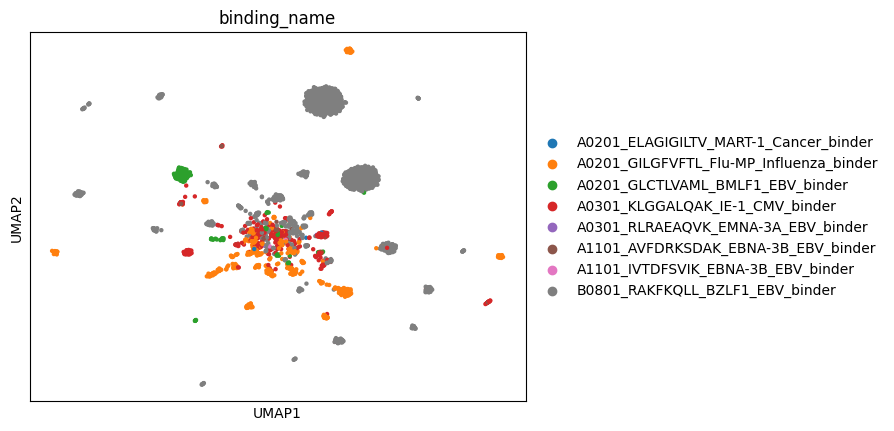

In [10]:
sc.pp.neighbors(latent_moe, use_rep='X')
sc.tl.umap(latent_moe)
sc.pl.umap(latent_moe, color='binding_name', ncols=1)

Note, that the latent representation is highly separated to small clusters, that are mainly formed by one clonotype. This is due to the limited computational time (n_epochs, n_samples) spent to train these models in this tutorial.